# 小型的房价预测

In [1]:
import hashlib
import os
import tarfile
import zipfile
import requests


In [2]:
DATA_HUB = dict()
DATA_URL="http://d2l-data.s3-accelerate.amazonaws.com/"

In [3]:
def download(name,cache_dir=os.path.join("..","data")):
    assert name in DATA_HUB, "不存在"
    url,sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir,exist_ok=True)
    fname = os.path.join(cache_dir,url.split("/")[-1])
    # 检查完整性
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname,"rb") as f:
            while True:
                # 每次读取1mb
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        # 比较hash 如果存在就返回 不存在就接着 下载
        if sha1.hexdigest()==sha1_hash:
            return fname
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [4]:
# 我们还需实现两个实用函数： 一个将下载并解压缩一个zip或tar文件， 另一个是将本书中使用的所有数据集从DATA_HUB下载到缓存目录中。
def download_extract(name,folder=None):
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir,ext = os.path.splitext(fname)
    if ext == ".zip":
        fp  = zipfile.ZipFile(fname,"r")
    elif ext in (".tar",".gz"):
        fp = tarfile.open(fname,"r")
    else:
        assert False
    fp.extractall(base_dir)
    return os.path.join(base_dir,folder) if folder else data_dir

In [5]:
def download_all():
    for name in DATA_HUB:
        download(name)

In [6]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l


In [7]:
# 下载缓存的数据集
DATA_HUB["kaggle_house_train"] = (DATA_URL+'kaggle_house_pred_train.csv','585e9cc93e70b39160e7921475f9bcd7d31219ce')
DATA_HUB['kaggle_house_test'] = ( 
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [8]:
train_data = pd.read_csv(download("kaggle_house_train"))
test_data = pd.read_csv(download("kaggle_house_test"))


In [9]:

print(train_data.info)



<bound method DataFrame.info of         Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0        1          60       RL         65.0     8450   Pave   NaN      Reg   
1        2          20       RL         80.0     9600   Pave   NaN      Reg   
2        3          60       RL         68.0    11250   Pave   NaN      IR1   
3        4          70       RL         60.0     9550   Pave   NaN      IR1   
4        5          60       RL         84.0    14260   Pave   NaN      IR1   
...    ...         ...      ...          ...      ...    ...   ...      ...   
1455  1456          60       RL         62.0     7917   Pave   NaN      Reg   
1456  1457          20       RL         85.0    13175   Pave   NaN      Reg   
1457  1458          70       RL         66.0     9042   Pave   NaN      Reg   
1458  1459          20       RL         68.0     9717   Pave   NaN      Reg   
1459  1460          20       RL         75.0     9937   Pave   NaN      Reg   

     LandContour Ut

In [10]:
print(train_data.describe)

<bound method NDFrame.describe of         Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0        1          60       RL         65.0     8450   Pave   NaN      Reg   
1        2          20       RL         80.0     9600   Pave   NaN      Reg   
2        3          60       RL         68.0    11250   Pave   NaN      IR1   
3        4          70       RL         60.0     9550   Pave   NaN      IR1   
4        5          60       RL         84.0    14260   Pave   NaN      IR1   
...    ...         ...      ...          ...      ...    ...   ...      ...   
1455  1456          60       RL         62.0     7917   Pave   NaN      Reg   
1456  1457          20       RL         85.0    13175   Pave   NaN      Reg   
1457  1458          70       RL         66.0     9042   Pave   NaN      Reg   
1458  1459          20       RL         68.0     9717   Pave   NaN      Reg   
1459  1460          20       RL         75.0     9937   Pave   NaN      Reg   

     LandContour 

In [11]:
# 让我们看看前四个和最后两个特征，以及相应标签（房价）
print(train_data.iloc[0:4,[0,1,2,3,-3,-2,-1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [12]:
print(test_data.shape)

(1459, 80)


In [13]:
# 删除id
all_features = pd.concat((train_data.iloc[:,1:-1],test_data.iloc[:,1:]))
print(all_features.shape)

(2919, 79)


In [14]:
# 数据预处理
numeric_features = all_features.dtypes[all_features.dtypes!="object"].index
all_features[numeric_features] = all_features[numeric_features].apply(lambda x:(x-x.mean())/(x.std()))
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [15]:
# 为字符串特征创建额外特征
all_features = pd.get_dummies(all_features,dummy_na=True)
all_features.shape

(2919, 330)

In [16]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values.astype(np.float32), dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values.astype(np.float32), dtype=torch.float32)
train_labels = torch.tensor(
    train_data.SalePrice.values.astype(np.float32).reshape(-1, 1), dtype=torch.float32)

In [54]:
from torch import nn
loss = nn.MSELoss()
in_features = train_features.shape[1]
def get_net():
    net = nn.Sequential(nn.Linear(in_features,1))
    return net

In [29]:
def log_rmse(net,features,labels):
    # torch.clamp() 函数用于对预测结果进行截断，将值限制在给定的范围内
    clipped_preds = torch.clamp(net(features),1,float("inf"))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),torch.log(labels)))
    return rmse.item()

In [38]:
# 借助adam优化器
def train(net,train_features,train_labels,test_features,test_labels,epochs,learn_rate,weight_decay,batch_size):
    train_ls,test_ls = [],[]
    train_iter = d2l.load_array((train_features,train_labels),batch_size)
    optimizer = torch.optim.Adam(net.parameters(),lr=learn_rate,weight_decay=weight_decay)
    for epoch in range(epochs):
        for X,y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X),y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net,train_features,train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net,test_features,test_labels))
    return train_ls,test_ls

In [39]:
# k折交叉验证 i 是第n折
def get_k_flod_data(k,i,X,y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train,y_train = None,None
    for j in range(k):
        # slice切片
        idx = slice(j*fold_size,(j+1)*fold_size)
        X_part ,y_part = X[idx,:],y[idx]
        if j == i:
            X_valid,y_valid = X_part,y_part
        elif X_train is None:
            X_train,y_train = X_part,y_part
        else:
            X_train = torch.cat([X_train,X_part],0)
            y_train = torch.cat([y_train,y_part],0)
    return X_train,y_train,X_valid,y_valid



In [44]:
# 当我们在折交叉验证中训练次后，返回训练和验证误差的平均值。
def k_fold(k,X_train,y_train,epochs,learning_rate,weight_decay,batch_size):
    train_ls,valid_ls = 0.0,0.0
    for i in range(k):
        data = get_k_flod_data(k,i,X_train,y_train)
        net = get_net()
        train_l,valid_l = train(net,*data,epochs,learning_rate,weight_decay,batch_size)
        train_ls += train_l[-1]
        valid_ls += valid_l[-1]
        if i==0:
            d2l.plot(list(range(1, epochs + 1)), [train_l, valid_l],
                     xlabel='epoch', ylabel='rmse', xlim=[1, epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log rmse{float(train_l[-1]):f}, '
              f'验证log rmse{float(valid_l[-1]):f}')
    return train_ls / k, valid_ls / k

折1，训练log rmse0.170224, 验证log rmse0.156592
折2，训练log rmse0.161797, 验证log rmse0.188413
折3，训练log rmse0.164041, 验证log rmse0.168472
折4，训练log rmse0.168598, 验证log rmse0.154735
折5，训练log rmse0.163508, 验证log rmse0.182916
5-折验证: 平均训练log rmse: 0.165633, 平均验证log rmse: 0.170226


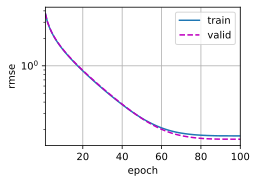

In [55]:
k,epochs,lr,weight_decay,batch_size = 5,100,5,0,64
train_l,valid_l = k_fold(k,train_features,train_labels,epochs,lr,weight_decay,batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

In [57]:
def train_and_pred(train_features,test_features,train_labels,test_data,epochs,lr,weight_decay,batch_size):
    net = get_net()
    train_ls,_ = train(net,train_features,train_labels,None,None,epochs,lr,weight_decay,batch_size)
    d2l.plot(np.arange(1, epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    preds = net(test_features).detach().numpy()
    test_data["SalePrice"] = pd.Series(preds.reshape(1,-1)[0])
    submission = pd.concat([test_data["Id"],test_data["SalePrice"]],axis=1)
    submission.to_csv("submission.csv",index=False)
    

训练log rmse：0.162537


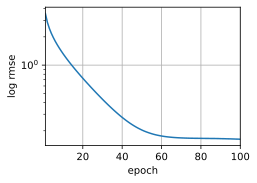

In [58]:
train_and_pred(train_features,test_features,train_labels,test_data,epochs,lr,weight_decay,batch_size)